# E-Commerce Sales Data Warehouse & Analysis

Ez a Jupyter Notebook bemutatja az OLTP → DWH → Elemzés folyamatot a Brazilian E-Commerce Public Dataset by Olist alapján.

**Fő lépések:**


---

In [18]:
# 1) modulok importálása
import os
import sqlite3
import pandas as pd
from pandas.errors import ParserError

# 2) CSV-k beolvasása a helyes sep/encoding paraméterekkel
data_dir = "./"    # a notebook és a CSV-k ugyanabban a mappában vannak
dfs = {}

# 2a) Translation fájl (fix beállítás)
dfs['translation'] = pd.read_csv(
    os.path.join(data_dir, "product_category_name_translation.csv"),
    sep=";", encoding="latin1", engine="python"
)

# 2b) CUSTOMERS — Python‐motor, idézőkarakter, hibás sorok átugrása
dfs['customers'] = pd.read_csv(
    os.path.join(data_dir, "olist_customers_dataset.csv"),
    sep=",", encoding="latin1", engine="python",
    quotechar='"', on_bad_lines="warn", dtype=str
)
assert 'customer_id' in dfs['customers'].columns, "Nincs customer_id az oszlopok között!"
dfs['customers'] = dfs['customers'].drop_duplicates("customer_id").reset_index(drop=True)
dfs['customers']['customer_key'] = dfs['customers'].index + 1

# 2c) A többi 7 fájl (alapesetben UTF-8, ha kell fallback)
files = {
    'geolocation':     "olist_geolocation_dataset.csv",
    'order_items':     "olist_order_items_dataset.csv",
    'order_payments':  "olist_order_payments_dataset.csv",
    'order_reviews':   "olist_order_reviews_dataset.csv",
    'orders':          "olist_orders_dataset.csv",
    'products':        "olist_products_dataset.csv",
    'sellers':         "olist_sellers_dataset.csv",
}

for name, fname in files.items():
    path = os.path.join(data_dir, fname)
    try:
        df = pd.read_csv(path, sep=",", encoding="utf-8")
    except (UnicodeDecodeError, ParserError):
        df = pd.read_csv(path, sep="\t", encoding="latin1", engine="python")
    dfs[name] = df

# 3) Surrogate kulcsok és dimenziók előállítása

# --- Dim_Date
dates = pd.to_datetime(dfs['orders']['order_purchase_timestamp'], errors='coerce')
dates = (
    dates.dropna().drop_duplicates().to_frame(name='full_date')
         .assign(
             year=lambda d: d['full_date'].dt.year,
             month=lambda d: d['full_date'].dt.month,
             day=lambda d: d['full_date'].dt.day,
             day_of_week=lambda d: d['full_date'].dt.dayofweek+1,
             quarter=lambda d: d['full_date'].dt.quarter
         )
         .sort_values('full_date').reset_index(drop=True)
)
dates['date_key'] = dates.index + 1

# --- Dim_Product
prod = (
    dfs['products'][[
        'product_id','product_category_name',
        'product_name_lenght','product_description_lenght'
    ]]
    .drop_duplicates('product_id').reset_index(drop=True)
    .rename(columns={
        'product_name_lenght': 'product_name_length',
        'product_description_lenght': 'product_description_len'
    })
)
prod['product_key'] = prod.index + 1

# --- Dim_Seller
sell = (
    dfs['sellers'][[
        'seller_id','seller_zip_code_prefix','seller_city','seller_state'
    ]]
    .drop_duplicates('seller_id').reset_index(drop=True)
)
sell['seller_key'] = sell.index + 1

# --- Dim_Payment
pay = (
    dfs['order_payments'][[
        'order_id','payment_sequential','payment_type','payment_installments'
    ]]
    .drop_duplicates(['order_id','payment_sequential']).reset_index(drop=True)
)
pay['payment_key'] = pay.index + 1

# 4) Fact_Sales összeállítása
oi = dfs['order_items']
o  = dfs['orders']
fact = (
    oi
     .merge(o[['order_id','customer_id','order_purchase_timestamp']], on='order_id', how='left')
     .merge(prod[['product_id','product_key']], on='product_id', how='left')
     .merge(dfs['customers'][['customer_id','customer_key']], on='customer_id', how='left')
     .merge(sell[['seller_id','seller_key']], on='seller_id', how='left')
     .merge(pay[['order_id','payment_key']], on='order_id', how='left')
)

fact['order_purchase_timestamp'] = pd.to_datetime(fact['order_purchase_timestamp'])
fact = fact.merge(
    dates[['full_date','date_key']],
    left_on='order_purchase_timestamp', right_on='full_date', how='left'
)

fact = fact.assign(
    quantity      = fact['order_item_id'],
    price         = fact['price'],
    freight_value = fact['freight_value']
)
fact['total_amount'] = fact['price']*fact['quantity'] + fact['freight_value']

fact = fact[[
    'order_id','product_key','customer_key','seller_key',
    'date_key','payment_key',
    'quantity','price','freight_value','total_amount'
]]

# 5) SQLite adatbázis és táblák létrehozása, betöltés
conn = sqlite3.connect('ecommerce_dwh.sqlite')
cur = conn.cursor()
cur.executescript("""
CREATE TABLE IF NOT EXISTS Dim_Date (
  date_key INTEGER PRIMARY KEY,
  full_date TEXT, year INTEGER, month INTEGER,
  day INTEGER, day_of_week INTEGER, quarter INTEGER
);
CREATE TABLE IF NOT EXISTS Dim_Product (
  product_key INTEGER PRIMARY KEY,
  product_id TEXT, product_category_name TEXT,
  product_name_length INTEGER, product_description_len INTEGER
);
CREATE TABLE IF NOT EXISTS Dim_Customer (
  customer_key INTEGER PRIMARY KEY,
  customer_id TEXT, customer_unique_id TEXT,
  zip_code_prefix TEXT, city TEXT, state TEXT
);
CREATE TABLE IF NOT EXISTS Dim_Seller (
  seller_key INTEGER PRIMARY KEY,
  seller_id TEXT, zip_code_prefix TEXT, city TEXT, state TEXT
);
CREATE TABLE IF NOT EXISTS Dim_Payment (
  payment_key INTEGER PRIMARY KEY,
  order_id TEXT, payment_type TEXT, payment_installments INTEGER
);
CREATE TABLE IF NOT EXISTS Fact_Sales (
  sales_key     INTEGER PRIMARY KEY AUTOINCREMENT,
  order_id      TEXT, product_key INTEGER,
  customer_key  INTEGER, seller_key INTEGER,
  date_key      INTEGER, payment_key INTEGER,
  quantity      INTEGER, price REAL,
  freight_value REAL, total_amount REAL,
  FOREIGN KEY(product_key)  REFERENCES Dim_Product(product_key),
  FOREIGN KEY(customer_key) REFERENCES Dim_Customer(customer_key),
  FOREIGN KEY(seller_key)   REFERENCES Dim_Seller(seller_key),
  FOREIGN KEY(date_key)     REFERENCES Dim_Date(date_key),
  FOREIGN KEY(payment_key)  REFERENCES Dim_Payment(payment_key)
);
""")

# — Dimenziók felülírása replace módban — 
dates.to_sql   ('Dim_Date',    conn, if_exists='replace', index=False)
prod.to_sql    ('Dim_Product', conn, if_exists='replace', index=False)

cust_df = dfs['customers'][[
    'customer_id','customer_unique_id',
    'customer_zip_code_prefix','customer_city','customer_state','customer_key'
]].rename(columns={
    'customer_zip_code_prefix': 'zip_code_prefix',
    'customer_city': 'city',
    'customer_state': 'state'
})
cust_df.to_sql('Dim_Customer', conn, if_exists='replace', index=False)

sell_df = sell.rename(columns={
    'seller_zip_code_prefix': 'zip_code_prefix',
    'seller_city':            'city',
    'seller_state':           'state'
})[[
    'seller_id','zip_code_prefix','city','state','seller_key'
]]
sell_df.to_sql('Dim_Seller', conn, if_exists='replace', index=False)

pay[['order_id','payment_type','payment_installments','payment_key']] \
    .to_sql('Dim_Payment', conn, if_exists='replace', index=False)

# — Fact tábla append módban —
fact.to_sql  ('Fact_Sales',  conn, if_exists='append', index=False)

conn.commit()
conn.close()

print("🏭 Az SQLite adattárház elkészült, dimenziók replace és fact append módban betöltve.")


🏭 Az SQLite adattárház elkészült, dimenziók replace és fact append módban betöltve.


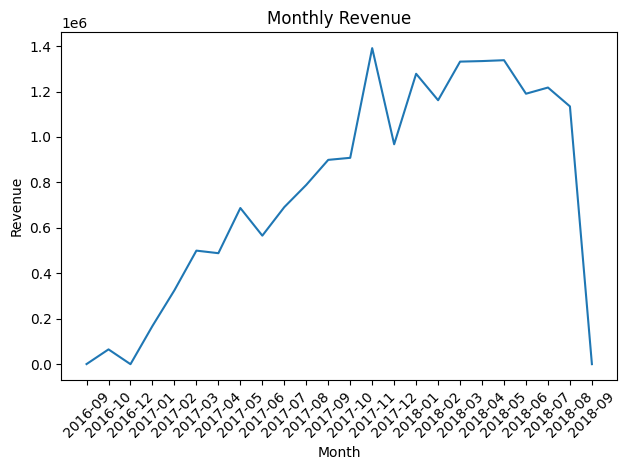

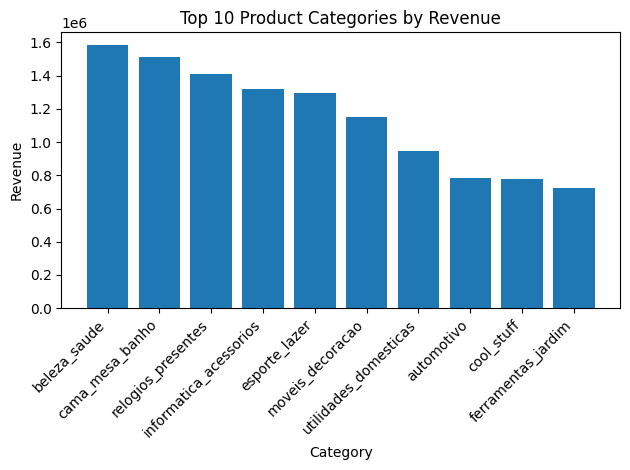

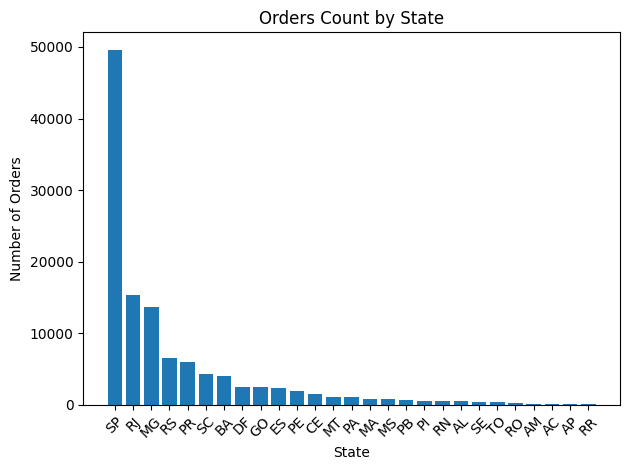

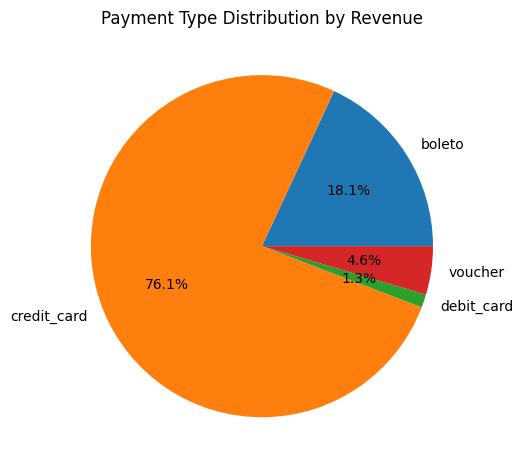

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# 1) Kapcsolódás az adattárházhoz
conn = sqlite3.connect('ecommerce_dwh.sqlite')

# 2) Monthly revenue idősoros lekérdezés
df_monthly = pd.read_sql_query("""
    SELECT 
        d.year || '-' || printf('%02d', d.month) AS year_month,
        SUM(f.total_amount) AS revenue
    FROM Fact_Sales f
    JOIN Dim_Date d ON f.date_key = d.date_key
    GROUP BY d.year, d.month
    ORDER BY d.year, d.month;
""", conn)

# 3) Top 10 termékkategória bevétel
df_top_cat = pd.read_sql_query("""
    SELECT 
        p.product_category_name AS category,
        SUM(f.total_amount) AS revenue
    FROM Fact_Sales f
    JOIN Dim_Product p ON f.product_key = p.product_key
    GROUP BY p.product_category_name
    ORDER BY revenue DESC
    LIMIT 10;
""", conn)

# 4) Államonkénti rendelési volumen
df_by_state = pd.read_sql_query("""
    SELECT 
        c.state AS state,
        COUNT(*) AS orders_count
    FROM Fact_Sales f
    JOIN Dim_Customer c ON f.customer_key = c.customer_key
    GROUP BY c.state
    ORDER BY orders_count DESC;
""", conn)

# 5) Fizetési típusok megoszlása
df_pay = pd.read_sql_query("""
    SELECT 
        p.payment_type,
        SUM(f.total_amount) AS total_amount
    FROM Fact_Sales f
    JOIN Dim_Payment p ON f.payment_key = p.payment_key
    GROUP BY p.payment_type;
""", conn)

conn.close()

# 6) Vizualizációk

# Monthly revenue line chart
plt.figure()
plt.plot(df_monthly['year_month'], df_monthly['revenue'])
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 categories bar chart
plt.figure()
plt.bar(df_top_cat['category'], df_top_cat['revenue'])
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Orders count by state bar chart
plt.figure()
plt.bar(df_by_state['state'], df_by_state['orders_count'])
plt.title('Orders Count by State')
plt.xlabel('State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Payment type distribution pie chart
plt.figure()
plt.pie(df_pay['total_amount'], labels=df_pay['payment_type'], autopct='%1.1f%%')
plt.title('Payment Type Distribution by Revenue')
plt.tight_layout()
plt.show()
